<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h1>A2: Modeling Case Study (Individual)</h1>
<br>Introduction to Machine Learning & AI - DAT-5329 - FMBANDD1</h4>
<br>Chase Kusterer - Faculty of Analytics<br>
Hult International Business School<br><br><br>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<br>



# Part I: Imports and Data Check

In [288]:
# Importing necessary libraries
import pandas as pd # Data manipulation and analysis library
import numpy as np # Library for numerical operations
import matplotlib.pyplot as plt # Plotting library for creating visualizations
import seaborn as sns # Enhanced visualization library based on matplotlib
import statsmodels.api as sm # Statistical models (including regression)
import statsmodels.formula.api as smf # Statistical models with formula notation
import sklearn.linear_model # Machine learning library for linear models
from sklearn.model_selection import train_test_split # Split data into random train and test subsets
from sklearn.linear_model import LogisticRegression # Logistic regression model
from sklearn.metrics import accuracy_score, classification_report # Metrics to evaluate classification performance
from sklearn.linear_model import RidgeClassifier # Ridge classifier model
from sklearn.tree import DecisionTreeClassifier # Decision tree model for classification tasks
from sklearn.ensemble import RandomForestClassifier # Random forest model for classification
from sklearn.ensemble import GradientBoostingClassifier # Gradient boosting model for classification
from sklearn.neighbors import KNeighborsClassifier # K-nearest neighbors classifier
from sklearn.metrics import mean_squared_error # Function to calculate mean squared error
from sklearn.preprocessing import StandardScaler # Feature scaling to standard normal distribution
from sklearn.model_selection import RandomizedSearchCV # Hyperparameter tuning through random search
from phik import resources, report # Phi_K correlation analysis and report generation
from sklearn.preprocessing import power_transform # Yeo-Johnson transformation (handling skewness in data)
from sklearn.preprocessing import StandardScaler # Standardize features by removing the mean and scaling to unit variance
from sklearn.model_selection import train_test_split # Splits arrays or matrices into random train and test subsets
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score # Different performance metrics for classification models
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay # Functions for creating and visualizing confusion matrix
from sklearn.inspection import permutation_importance # Permutation importance for feature evaluation


In [289]:
import pandas as pd

# Path to the CSV file
modeling_data = './datasets/birthweight.csv'

# Reading the CSV file into a DataFrame called df_train
df_train = pd.read_csv(modeling_data, header=0, index_col='obs_id')

# Path to another CSV file for testing data
testing_data = './datasets/kaggle_test_data.csv'

# Reading the CSV file into a DataFrame called df_test
df_test = pd.read_csv(testing_data, header=0, index_col='obs_id')


In [290]:
#Checking the dataset
df_train.head(n=5)

,mage,meduc,monpre,npvis,fage,feduc,omaps,fmaps,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght
obs_id,,,,,,,,,,,,,,,,,,
id_0001,33,12.0,1.0,5.0,31.0,11.0,NaN,NaN,0.0,0.0,1,1,0,0,1,0,0,360
id_0002,30,14.0,2.0,6.0,31.0,14.0,4.0,6.0,0.0,0.0,0,1,0,0,1,0,0,506
id_0003,28,14.0,1.0,7.0,29.0,16.0,2.0,5.0,0.0,0.0,0,1,0,0,1,0,0,680
id_0005,26,NaN,5.0,2.0,21.0,NaN,4.0,7.0,0.0,0.0,1,0,1,0,0,1,0,697
id_0006,31,16.0,2.0,5.0,32.0,16.0,NaN,NaN,0.0,0.0,1,1,0,0,1,0,0,737


# Analysis Introduction 

The analysis aims to predict low birth weight using a dataset containing a variety of maternal and paternal factors. The dataset includes significant variables such as maternal age (mage), maternal education (meduc), prenatal care visits (npvis), paternal age (fage), paternal education (feduc), cigarette consumption during pregnancy (cigs), alcohol consumption during pregnancy (drink), and categorical variables such as gender (male) and ethnicity indicators (mwhte, mblck, moth, fwhte, fblck, foth). The goal is to develop a predictive model that uses these variables to accurately estimate birth weight. The exploratory data analysis will be important for gaining insight into variable distribution, identifying trends, and evaluating missing values. Next, feature engineering approaches will be used, followed by a systematic approach to create and assess candidate models.

In [291]:
# Correlation matrix focused on 'bwght' BEFORE THE threshold calculation 
correlation_matrix = df_train.corr(method='pearson')
correlation_matrix['bwght'].sort_values(ascending=False).round(2)

bwght     1.00
fmaps     0.17
omaps     0.17
npvis     0.10
fage      0.07
male      0.07
fwhte     0.07
mwhte     0.05
feduc     0.05
meduc     0.04
mage      0.03
monpre   -0.00
fblck    -0.02
drink    -0.02
mblck    -0.02
moth     -0.05
foth     -0.07
cigs     -0.09
Name: bwght, dtype: float64

## Official Threshold

In [292]:
# Assuming 'bwght' is the column in df_train for birth weight in grams
df_train['low_bwght'] = (df_train['bwght'] < 2500).astype(int)


In [293]:
# Check the distribution of 'low_bwght' in the training dataset
low_bwght_distribution = df_train['low_bwght'].value_counts()
print(low_bwght_distribution)


low_bwght
0    1564
1      84
Name: count, dtype: int64


Based on the distribution of target variable low_bwght in the training dataset, there are 300 instances classified as not low birth weight (0) and 84 instances classified as low birth weight (1). This confirms that dataset is imbalanced, with a higher proportion of instances belonging to the not low birth weight category.

### Balancing the dataset
Imbalanced datasets can lead to models that are biased towards the majority class, as they tend to predict the majority class better due to its higher prevalence. Sampling aims to balance the class distribution, which can help the model learn better and improve its performance on the minority class.

The sampling strategy applied here is Undersampling the Majority Class. This technique involves reducing the number of instances in the majority class to balance the dataset. Specifically, you randomly selected 300 instances from the low_bwght == 0 class (not low birth weight) to match the already existing number of instances in the majority class, rather than reducing the majority class to exactly match the minority class size, which would drastically reduce the dataset size and potentially lead to the loss of valuable information

In [294]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming df_train is your DataFrame

# Extracting rows where low_bwght is 0 and where low_bwght is 1
df_low_bwght_0 = df_train[df_train['low_bwght'] == 0]
df_low_bwght_1 = df_train[df_train['low_bwght'] == 1]

# Randomly selecting 300 samples from the df_low_bwght_0
df_sample_0 = df_low_bwght_0.sample(n=300, random_state=42)

# Combining the samples into a single dataframe and shuffling it
df_train = pd.concat([df_sample_0, df_low_bwght_1]).sample(frac=1, random_state=42)

# Verifying the sample size for each class in the combined sample
df_train['low_bwght'].value_counts()



low_bwght
0    300
1     84
Name: count, dtype: int64

In [295]:
#!#########################!#
#!# set response variable #!#
#!#########################!#
y_variable = "low_bwght" 

In [296]:
df_train.head(5)

,mage,meduc,monpre,npvis,fage,feduc,omaps,fmaps,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,low_bwght
obs_id,,,,,,,,,,,,,,,,,,,
id_1383,28,12.0,1.0,13.0,31.0,14.0,8.0,9.0,0.0,0.0,0,1,0,0,1,0,0,3771,0
id_0905,22,12.0,6.0,8.0,34.0,12.0,8.0,9.0,0.0,0.0,1,1,0,0,1,0,0,3415,0
id_0061,33,16.0,2.0,12.0,31.0,16.0,9.0,9.0,0.0,0.0,1,1,0,0,1,0,0,2290,1
id_0036,32,16.0,1.0,12.0,31.0,16.0,9.0,9.0,NaN,NaN,1,1,0,0,1,0,0,2050,1
id_0729,26,16.0,3.0,12.0,28.0,16.0,9.0,10.0,0.0,0.0,0,1,0,0,1,0,0,3290,0


# Part II: Data Preparation


## Base Modeling

In [297]:
# INFOrmation about each variable
df_train.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 384 entries, id_1383 to id_0286
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mage       384 non-null    int64  
 1   meduc      379 non-null    float64
 2   monpre     384 non-null    float64
 3   npvis      374 non-null    float64
 4   fage       381 non-null    float64
 5   feduc      375 non-null    float64
 6   omaps      382 non-null    float64
 7   fmaps      382 non-null    float64
 8   cigs       362 non-null    float64
 9   drink      361 non-null    float64
 10  male       384 non-null    int64  
 11  mwhte      384 non-null    int64  
 12  mblck      384 non-null    int64  
 13  moth       384 non-null    int64  
 14  fwhte      384 non-null    int64  
 15  fblck      384 non-null    int64  
 16  foth       384 non-null    int64  
 17  bwght      384 non-null    int64  
 18  low_bwght  384 non-null    int32  
dtypes: float64(9), int32(1), int64(9)
memory usag

In [298]:
# analyzing feature distributions
df_train.describe(include = 'number').round(decimals = 2) 

,mage,meduc,monpre,npvis,fage,feduc,omaps,fmaps,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,low_bwght
count,384.00,379.00,384.00,374.00,381.00,375.00,382.00,382.00,362.00,361.00,384.00,384.0,384.00,384.00,384.0,384.00,384.00,384.00,384.00
mean,29.39,13.75,2.07,11.45,31.44,14.01,8.16,8.94,1.09,0.02,0.52,0.9,0.05,0.04,0.9,0.06,0.04,3167.06,0.22
std,5.22,2.07,1.24,3.81,5.98,2.30,1.47,0.57,4.37,0.28,0.50,0.3,0.23,0.21,0.3,0.23,0.21,779.51,0.41
min,16.00,5.00,0.00,0.00,18.00,3.00,1.00,5.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,360.00,0.00
25%,26.00,12.00,1.00,10.00,28.00,12.00,8.00,9.00,0.00,0.00,0.00,1.0,0.00,0.00,1.0,0.00,0.00,2707.50,0.00
50%,29.00,13.00,2.00,12.00,31.00,14.00,9.00,9.00,0.00,0.00,1.00,1.0,0.00,0.00,1.0,0.00,0.00,3295.00,0.00
75%,33.00,16.00,2.00,12.00,35.00,16.00,9.00,9.00,0.00,0.00,1.00,1.0,0.00,0.00,1.0,0.00,0.00,3714.00,0.00
max,44.00,17.00,8.00,35.00,62.00,17.00,9.00,10.00,40.00,5.00,1.00,1.0,1.00,1.00,1.0,1.00,1.00,5160.00,1.00


Summary Statistics



1.  Parental Ages : Both mothers and fathers are in their early thirties and late twenties on average, respectively, with a moderate spread in ages, suggesting diverse parental age demographics.

2.  Education Levels : Average education suggests that most parents have completed high school and some college.

3.  Prenatal Care : The average start time for prenatal care is in the second month, and the average number of visits suggests reasonable prenatal healthcare engagement.

4.  Health Behaviors : There is significant variation in smoking habits, which may be a risk factor for birth outcomes, while alcohol consumption is minimal on average.

5.  Apgar Scores : Average scores are good, indicating newborns are generally healthy post-birth.

6.  Birth Weight : There's substantial variation in birth weights, with the minimum pointing to potential cases of very low birth weight.

7.  Demographics : The dataset likely represents a population with a majority of white parents and a balanced distribution of newborn genders.

8.  Low Birth Weight Incidence : The mean value for the `low_bwght` variable suggests around 22% of the newborns may be categorized as low birth weight, which is a significant proportion and an important outcome to be addressed.



C:\Users\racha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


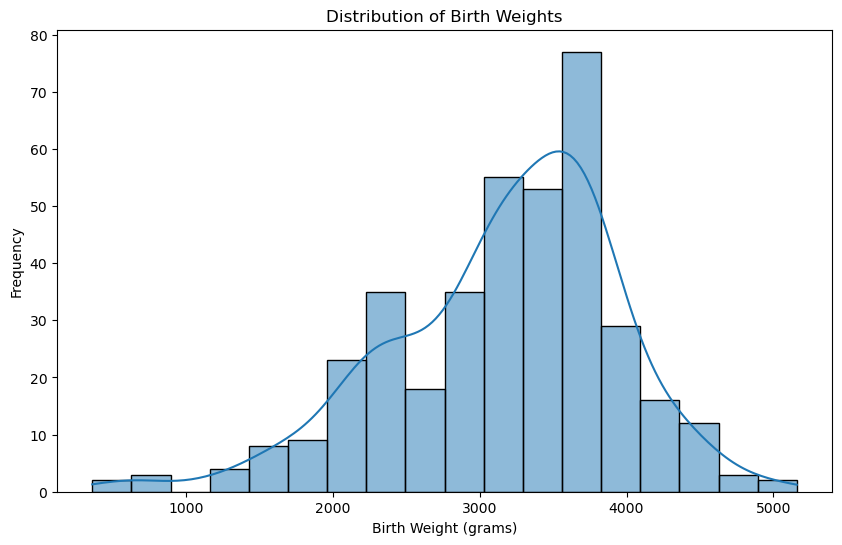

In [299]:
# Plotting the distribution of birth weights
plt.figure(figsize=(10, 6))
sns.histplot(df_train['bwght'], kde=True)
plt.title('Distribution of Birth Weights')
plt.xlabel('Birth Weight (grams)')
plt.ylabel('Frequency')
plt.show()


Distribution of Birth Weights

1.  Central Tendency : The majority of birth weights are clustered around the 3000-gram, which is typical for full-term newborns, indicating a normal distribution around this central value.

2.  Spread and Variability : The distribution of birth weights has a broad spread, ranging from less than 1000 grams to over 5000 grams, which implies a substantial variability in birth weights in the dataset.

3.  Skewness : There is a slight right skew to the data, with a tail extending towards the higher birth weights. This indicates that there are more babies with higher birth weights than lower in the dataset, although the highest frequency of birth weights remains around the mean.

4.  Low Birth Weight Frequency : There are a noticeable number of cases below 2500 grams, which is the typical threshold for low birth weight. These represent a critical subgroup possibly at risk for various health complications.

5.  Outliers or Extreme Values : There are a few birth weights that are quite high, notably some above 4500 grams, which are well above the average and could be considered outliers.

6.  KDE Fit : The KDE line suggests the data is not perfectly normally distributed, with deviations particularly in the tails, indicating the presence of outliers or extreme values.





## correlation_matrix 

In [300]:
# Correlation matrix focused on 'bwght'
correlation_matrix = df_train.corr(method='pearson')
correlation_matrix['bwght'].sort_values(ascending=False).round(2)

bwght        1.00
fmaps        0.36
omaps        0.34
npvis        0.17
feduc        0.09
male         0.08
fage         0.06
fwhte        0.04
mwhte        0.03
mage         0.03
meduc        0.03
drink       -0.00
monpre      -0.00
moth        -0.02
fblck       -0.02
foth        -0.03
mblck       -0.03
cigs        -0.14
low_bwght   -0.79
Name: bwght, dtype: float64

Pearson Correlation Insights:
Strongest Negative Correlation: The most negative correlation with birth weight is low_bwght (-0.79), which is expected as low_bwght likely represents a binary indicator for low birth weight, directly opposing the bwght value.

Negative Correlators: Smoking (cigs) shows a notable negative correlation with birth weight (-0.14), suggesting that higher cigarette consumption is associated with lower birth weights. Similarly, alcohol consumption (drink) is negatively correlated, though its coefficient is quite small (-0.002736).

Positive Correlators: The highest positive correlations with birth weight are Apgar scores (fmaps and omaps), indicating that higher Apgar scores are associated with higher birth weights. This reflects well on the general health and vitality of the newborns. The number of prenatal visits (npvis) also has a positive correlation, implying that more frequent healthcare interactions during pregnancy could be associated with healthier birth weights.

In [301]:
# Calculate the phi_k correlation matrix
phi_k_corr_matrix = df_train.phik_matrix()

# Display the phi_k correlation with 'bwght'
phi_k_corr_with_bwght = phi_k_corr_matrix[['bwght']].sort_values(by='bwght', ascending=False)
print(phi_k_corr_with_bwght)


interval columns not set, guessing: ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'omaps', 'fmaps', 'cigs', 'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 'bwght', 'low_bwght']
              bwght
bwght      1.000000
low_bwght  0.989053
fmaps      0.531901
omaps      0.500014
npvis      0.274909
feduc      0.182550
cigs       0.126651
foth       0.077764
moth       0.069749
fblck      0.048515
mblck      0.046252
fwhte      0.031730
mage       0.000000
mwhte      0.000000
male       0.000000
meduc      0.000000
fage       0.000000
monpre     0.000000
drink      0.000000


Phi_k Correlation

The Phi_k correlation coefficient is a newer statistic designed to measure association between variables, including nominal, ordinal, and interval data, often providing a more nuanced view of relationships.

High Phi_k with Low Birth Weight: The very high Phi_k correlation between low_bwght (0.989053) and bwght further underscores their direct and strong inverse relationship.

Strong Positive Correlations: The Apgar scores (omaps and fmaps) again show strong positive correlations with birth weight in the Phi_k matrix, even more pronounced than in the Pearson results. This highlights the importance of the Apgar test as an indicator of newborn health relative to birth weight.

Other Notable Correlations: Unlike the Pearson correlation, Phi_k identifies significant associations with parental age (fage and mage), racial factors (fwhte, foth, fblck, mwhte), and smoking (cigs). The presence of non-zero correlations for variables that had a zero Pearson correlation (e.g., meduc, mblck, monpre, drink) in the Phi_k matrix might be due to its ability to capture non-linear relationships.

## Base model: OLS 

In [302]:
lm_best = smf.ols(formula = """bwght ~ Q("mage") +
                                           Q("meduc") +
                                           Q("monpre") +  
                                           Q("npvis") +
                                           Q("fage") +
                                           Q("feduc") +
                                           Q("omaps") +
                                           Q("fmaps")+
                                           Q("cigs")+
                                           Q("drink")+
                                           Q("male")+
                                           Q("mwhte")+
                                           Q("mblck")+
                                           Q("moth")+
                                           Q("fwhte")+
                                           Q("fblck")+
                                           Q("foth")""",
                  data = df_train)
results = lm_best.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  bwght   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     4.758
Date:                Sun, 10 Mar 2024   Prob (F-statistic):           2.49e-08
Time:                        15:33:12   Log-Likelihood:                -2702.2
No. Observations:                 341   AIC:                             5436.
Df Residuals:                     325   BIC:                             5498.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -572.5321    430.741     -1.329      

Low Model Fit: The model explains only 18% of the variance in birth weight, indicating limited predictive power.

Significant Factors: Higher 5-minute Apgar scores are associated with higher birth weights, and cigarette smoking is associated with lower birth weights.

Multicollinearity Warning: Indicators suggest potential multicollinearity, which can undermine the reliability of the coefficient estimates.

# Missing Value Analysis and Imputation

In [303]:
# Checking for missing values in the dataset
df_train.isnull().sum()


mage          0
meduc         5
monpre        0
npvis        10
fage          3
feduc         9
omaps         2
fmaps         2
cigs         22
drink        23
male          0
mwhte         0
mblck         0
moth          0
fwhte         0
fblck         0
foth          0
bwght         0
low_bwght     0
dtype: int64

In [304]:
# Imputing missing values with median for numerical columns
df_train['meduc'].fillna(df_train['meduc'].median(), inplace=True)
df_train['monpre'].fillna(df_train['meduc'].median(), inplace=True)
df_train['npvis'].fillna(df_train['npvis'].median(), inplace=True)
df_train['fage'].fillna(df_train['fage'].median(), inplace=True)
df_train['feduc'].fillna(df_train['feduc'].median(), inplace=True)
df_train['omaps'].fillna(df_train['feduc'].median(), inplace=True)
df_train['fmaps'].fillna(df_train['feduc'].median(), inplace=True)
df_train['cigs'].fillna(df_train['cigs'].median(), inplace=True)
df_train['drink'].fillna(df_train['drink'].median(), inplace=True)

# Checking the dataset again for any remaining missing values
df_train.isnull().sum()

mage         0
meduc        0
monpre       0
npvis        0
fage         0
feduc        0
omaps        0
fmaps        0
cigs         0
drink        0
male         0
mwhte        0
mblck        0
moth         0
fwhte        0
fblck        0
foth         0
bwght        0
low_bwght    0
dtype: int64

In [305]:
# Checking for missing values in the dataset
df_test.isnull().sum()

mage       0
meduc      5
monpre     1
npvis     12
fage       0
feduc     10
omaps      0
fmaps      0
cigs       9
drink     10
male       0
mwhte      0
mblck      0
moth       0
fwhte      0
fblck      0
foth       0
dtype: int64

In [306]:
## Imputing missing values with median for numerical columns for test dataset 
df_test['meduc'].fillna(df_test['meduc'].median(), inplace=True)
df_test['monpre'].fillna(df_test['meduc'].median(), inplace=True)
df_test['npvis'].fillna(df_test['npvis'].median(), inplace=True)
df_test['feduc'].fillna(df_test['feduc'].median(), inplace=True)
df_test['cigs'].fillna(df_test['cigs'].median(), inplace=True)
df_test['drink'].fillna(df_test['drink'].median(), inplace=True)


Imputing the missing value with median for both training and testing datasets 

## Skewness Bar Chart:

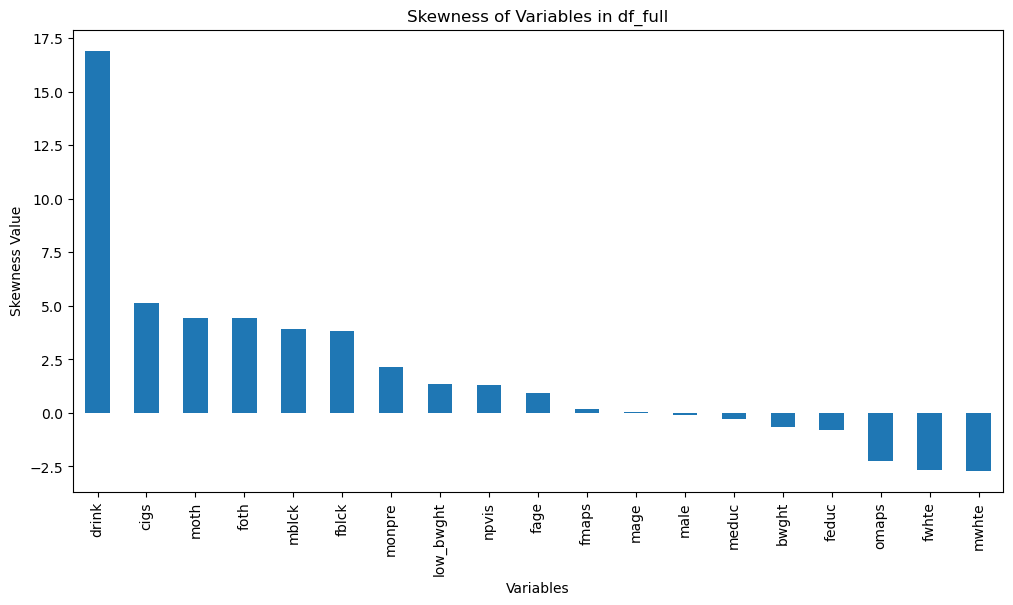

In [307]:
## Transformations ##
# Getting the skewness
skew_values = df_train.skew()

# Sort the skewness values in descending order
skew_values_sorted = skew_values.sort_values(ascending=False)

# Plotting the skewness values
plt.figure(figsize=(12, 6))
skew_values_sorted.plot(kind='bar')
plt.title('Skewness of Variables in df_full')
plt.xlabel('Variables')
plt.ylabel('Skewness Value')
plt.show()

High positive skewness for variables like drink and cigs indicates a long tail of high values, suggesting outliers or infrequent extreme consumption. Variables with lower skewness, such as fage and mage, have distributions closer to normal. A few variables, notably fmaps, mwhte, fwhte, and omaps, show negative skewness, indicating a longer left tail. Highly skewed variables might need transformation for certain types of statistical analysis to meet normality assumptions.

In [308]:
# Calculating skewness for numerical features in the training dataset
skewness = df_train.skew()

# Filtering skewness for a clearer overview, displaying skewness values
# We're particularly interested in skewness values far from zero, indicating significant skewness
skewness_filtered = skewness[abs(skewness) > 0.5].sort_values(ascending=False) # Filtering to show only significantly skewed features

skewness_filtered


drink        16.915105
cigs          5.137960
moth          4.448486
foth          4.448486
mblck         3.932464
fblck         3.824855
monpre        2.136202
low_bwght     1.366014
npvis         1.288963
fage          0.941938
bwght        -0.682570
feduc        -0.786798
omaps        -2.263363
fwhte        -2.648386
mwhte        -2.696637
dtype: float64

In [309]:
import numpy as np

# Applying log transformation to 'drink' and 'cigs'
df_train['log_drink'] = np.log1p(df_train['drink'])
df_train['log_cigs'] = np.log1p(df_train['cigs'])

# Checking the skewness after transformation
print(df_train[['log_drink', 'log_cigs']].skew())


log_drink    13.128822
log_cigs      3.487793
dtype: float64


In [310]:
# Calculating skewness for numerical features in the training dataset
skewness = df_test.skew()

# Filtering skewness for a clearer overview, displaying skewness values
# We're particularly interested in skewness values far from zero, indicating significant skewness
skewness_filtered = skewness[abs(skewness) > 0.5].sort_values(ascending=False) # Filtering to show only significantly skewed features

skewness_filtered


drink     10.871212
mblck      5.306472
cigs       4.902931
fblck      4.869410
foth       4.869410
moth       4.217265
monpre     4.110946
fage       1.113931
feduc     -0.639815
mwhte     -3.083861
fwhte     -3.224031
omaps     -3.617550
fmaps     -4.220630
dtype: float64

In [311]:
import numpy as np

# Applying log transformation to 'drink' and 'cigs' in df_test
df_test['log_drink'] = np.log1p(df_test['drink'])
df_test['log_cigs'] = np.log1p(df_test['cigs'])

# Checking the skewness after transformation
new_skewness = df_test[['log_drink', 'log_cigs']].skew()
print(new_skewness)


log_drink    10.203553
log_cigs      3.789316
dtype: float64


Log Transformation Attempt: An attempt was made to normalize 'drink' and 'cigs' by applying a log transformation. Despite this effort, 'log_drink' and 'log_cigs' remain highly skewed, though the skewness is reduced, suggesting that the transformation did not fully normalize the data, potentially due to zeros or near-zero values that are unaffected by the log transformation.

In [312]:
# Now, calculating the phi coefficient for correlation
birth_phi_corr = df_train.phik_matrix().round(decimals=4)

# Checking the results for 'bwght'
correlation_with_bwght = birth_phi_corr.loc[:, 'low_bwght'].sort_values(ascending=False).to_frame(name='Correlation with Low Birthweight')
correlation_with_bwght.reset_index(inplace=True)
correlation_with_bwght.rename(columns={'index': 'Variable'}, inplace=True)

# Printing the reults 
correlation_with_bwght

interval columns not set, guessing: ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'omaps', 'fmaps', 'cigs', 'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 'bwght', 'low_bwght', 'log_drink', 'log_cigs']


,Variable,Correlation with Low Birthweight
0,low_bwght,1.0000
1,bwght,0.9891
2,omaps,0.4858
3,fmaps,0.3233
4,npvis,0.2153
5,log_cigs,0.1779
6,feduc,0.1563
7,meduc,0.1255
8,cigs,0.1222
9,fwhte,0.0000


#  Feature Engineering </h3><br>

1.apgar_npvis_interaction: 

This feature combines Apgar scores (omaps and fmaps) and number of prenatal visits (npvis). The Apgar score is a quick test given to a baby between 1 and 5 minutes after birth to assess their health status, which includes heart rate, breathing, muscle tone, reflex response, and color. By multiplying the sum of these scores by the number of prenatal visits, this feature attempts to capture the relationship between the baby's initial health status and the amount of prenatal care received. It operates on the assumption that more prenatal 

2.mage_bracket and fage_bracket: 

These features divide maternal and paternal ages (mage and fage) into brackets or groups ('young','middle-aged', and 'older') based on predefined age ranges. The rationale here is to investigate the impact of parental age on birth outcomes in greater detail. Different age groups may have different risks or associations with birth weight, and categorizing ages can aid in detecting these patterns.

3.health_behavior_score: 

The underlying assumption is that these health behaviors negatively impact fetal development, with higher scores indicating potentially greater risk to the baby's health, including birth weight. By combining them into a single score, this feature seeks to capture the cumulative impact of maternal smoking and drinking habits on birth weight.

4 prenatal_care_index:

This feature is designed to provide a measure of prenatal care quality, calculated as the number of prenatal visits (npvis) adjusted by the month prenatal care began (monpre). The idea is that starting prenatal care earlier and attending more visits are both indicators of better prenatal care. This index could highlight the importance of early and frequent prenatal care in predicting birth weight outcomes. The division by monpre adjusts the visit count to emphasize the timing of care initiation—earlier starts lead to higher index values, suggesting potentially better prenatal care engagement.

5.weighted_parental_age:

By weighting the ages of the mother and father differently (in this case, giving more weight to the mother's age), this feature acknowledges that maternal age might have a more significant impact on birth outcomes than paternal age. The weights (0.6 for maternal age and 0.4 for paternal age) reflect a presumed higher importance of maternal age in influencing birth outcomes, such as birth weight. This weighted average attempts to create a single metric that captures the combined effect of parental ages, with an emphasis on the mother's age.

6.prenatal_adequacy: 

This binary feature is created based on the number of prenatal visits (npvis), marking 1 for adequate prenatal care (defined here as having 8 or more visits) and 0 for inadequate care. The threshold of 8 visits is likely chosen based on healthcare guidelines or literature that define a minimum number of prenatal visits for a pregnancy to be considered well-monitored. This feature is designed to directly assess the adequacy of prenatal care in relation to birth weight outcomes, with the hypothesis that adequate prenatal care is associated with healthier birth weights.

C:\Users\racha\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


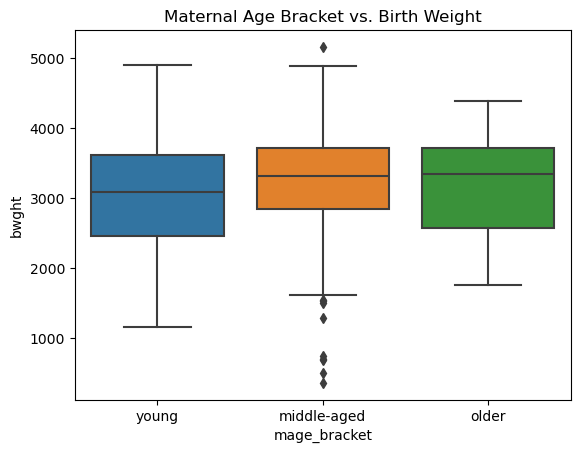

In [313]:
df_train['apgar_npvis_interaction'] = (df_train['omaps'] + df_train['fmaps']) * df_train['npvis']
df_train['mage_bracket'] = pd.cut(df_train['mage'], bins=[0, 24, 35, max(df_train['mage'])], labels=['young', 'middle-aged', 'older'])
df_train['fage_bracket'] = pd.cut(df_train['fage'], bins=[0, 24, 35, max(df_train['fage'])], labels=['young', 'middle-aged', 'older'])
# Example for 'mage_bracket'
sns.boxplot(data=df_train, x='mage_bracket', y='bwght')
plt.title('Maternal Age Bracket vs. Birth Weight')
plt.show()

df_train['mage_bracket'] = pd.cut(df_train['mage'], bins=[0, 24, 35, max(df_train['mage'])], labels=['young', 'middle-aged', 'older'])
df_train['fage_bracket'] = pd.cut(df_train['fage'], bins=[0, 24, 35, max(df_train['fage'])], labels=['young', 'middle-aged', 'older'])


This visual analysis emphasizes the need to consider maternal age in prenatal care strategies, potentially tailoring interventions for middle-aged expectant mothers who exhibit a wider range of birth weights, thereby addressing the factors contributing to this variability.

In [314]:
# 'health_behavior_score'
df_train['health_behavior_score'] = (-1) * df_train['cigs'] + (-1) * df_train['drink']  # Assuming higher values are worse
#'prenatal_care_index'
df_train['prenatal_care_index'] = df_train['npvis'] * (1 / df_train['monpre'])
# Weighted Features
# Weight mother's age more if it is deemed more important
df_train['weighted_parental_age'] = df_train['mage'] * 0.6 + df_train['fage'] * 0.4
# Prenatal Care Adequacy
df_train['prenatal_adequacy'] = np.where(df_train['npvis'] >= 8, 1, 0)


In [315]:
df_test['apgar_npvis_interaction'] = (df_test['omaps'] + df_test['fmaps']) * df_test['npvis']
df_test['mage_bracket'] = pd.cut(df_test['mage'], bins=[0, 24, 35, max(df_test['mage'])], labels=['young', 'middle-aged', 'older'])
df_test['fage_bracket'] = pd.cut(df_test['fage'], bins=[0, 24, 35, max(df_test['fage'])], labels=['young', 'middle-aged', 'older'])
# Assuming 'cigs' and 'drink' are already normalized or their scales are comparable
df_test['health_behavior_score'] = df_test['cigs'] + df_test['drink']
df_test['prenatal_care_index'] = df_test['npvis'] * (1 / df_test['monpre'])
# Weighted Features
# Weight mother's age more if it is deemed more important
df_test['weighted_parental_age'] = df_test['mage'] * 0.6 + df_test['fage'] * 0.4
# Prenatal Care Adequacy
df_test['prenatal_adequacy'] = np.where(df_test['npvis'] >= 8, 1, 0)


## one-hot encoding

In [316]:
#converting  categorical variables into dummy 
df_train= pd.get_dummies(df_train, columns=['mage_bracket', 'fage_bracket'], drop_first=True)


In [317]:
#converting  categorical variables into dummy 
df_test= pd.get_dummies(df_test, columns=['mage_bracket', 'fage_bracket'], drop_first=True)


In [318]:
# Now, calculating the phi coefficient for correlation
birth_phi_corr = df_train.phik_matrix().round(decimals=4)

# Checking the results for 'bwght'
correlation_with_bwght = birth_phi_corr.loc[:, 'low_bwght'].sort_values(ascending=False).to_frame(name='Correlation with Low Birthweight')
correlation_with_bwght.reset_index(inplace=True)
correlation_with_bwght.rename(columns={'index': 'Variable'}, inplace=True)

# Printing the reults 
correlation_with_bwght

interval columns not set, guessing: ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'omaps', 'fmaps', 'cigs', 'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 'bwght', 'low_bwght', 'log_drink', 'log_cigs', 'apgar_npvis_interaction', 'health_behavior_score', 'prenatal_care_index', 'weighted_parental_age', 'prenatal_adequacy']


,Variable,Correlation with Low Birthweight
0,low_bwght,1.0000
1,bwght,0.9891
2,omaps,0.4858
3,fmaps,0.3233
4,apgar_npvis_interaction,0.2984
5,prenatal_adequacy,0.2807
6,npvis,0.2153
7,log_cigs,0.1779
8,health_behavior_score,0.1721
9,feduc,0.1563


bwght (birth weight) has a very high correlation with low_bwght (0.9891), suggesting that as birth weight decreases, the likelihood of being classified as low birth weight increases.
Obstetric scores (omaps and fmaps) also show moderate correlations (0.4858 and 0.3233, respectively), indicating they're relevant factors in predicting low birth weight.
The apgar_npvis_interaction, which might represent an interaction between the Apgar score and the number of prenatal visits, shows a meaningful correlation (0.2984), possibly highlighting the importance of prenatal care.
Interestingly, both npvis (number of prenatal visits) and factors related to health behavior (log_cigs for logged cigarette consumption, and health_behavior_score) are less correlated than bwght but still show a positive relationship with low birth weight.
Variables transformed to reduce skewness (log_cigs and log_drink) show a different correlation compared to their original forms, with log_cigs showing a noticeable correlation (0.1779) while log_drink does not (0.0000), emphasizing the impact of transformation on statistical relationships.
Many variables, especially demographic and prenatal care index variables, have a zero correlation coefficient with low_bwght, suggesting no linear association within this dataset. It's important to note that a zero phi coefficient doesn't mean there is no relationship, but rather that any relationship isn't linear or it might be that these variables don't affect the likelihood of low birth weight within the scope of this dataset.
The results suggest that while some factors are strongly associated with low birth weight, others show little to no linear relationship in this context.

# Data Partitioning

In [319]:
#!###########################!#
#!# choose your x-variables #!#
#!###########################!#

x_features = ['drink', 'cigs','mage','meduc','monpre','npvis','fage','feduc','male','mwhte','mblck','apgar_npvis_interaction','health_behavior_score','mage_bracket_middle-aged','mage_bracket_older','fage_bracket_middle-aged','fage_bracket_older','prenatal_adequacy']


## ########################### ##
## DON'T CHANGE THE CODE BELOW ##
## ########################### ##

# prepping data for train-test split
x_data = df_train[x_features]

y_data = df_train[y_variable]


# train-test split (to validate the model)
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size    = 0.25,
                                                    random_state = 702 )


# results of train-test split
print(f"""
Original Dataset Dimensions
---------------------------
Observations (Rows): {df_train.shape[0]}
Features  (Columns): {df_train.shape[1]}


Training Data (X-side)
----------------------
Observations (Rows): {x_train.shape[0]}
Features  (Columns): {x_train.shape[1]}


Training Data (y-side)
----------------------
Feature Name:        {y_train.name}
Observations (Rows): {y_train.shape[0]}


Testing Data (X-side)
---------------------
Observations (Rows): {x_test.shape[0]}
Features  (Columns): {x_test.shape[1]}


Testing Data (y-side)
---------------------
Feature Name:        {y_test.name}
Observations (Rows): {y_test.shape[0]}""")


Original Dataset Dimensions
---------------------------
Observations (Rows): 384
Features  (Columns): 30


Training Data (X-side)
----------------------
Observations (Rows): 288
Features  (Columns): 18


Training Data (y-side)
----------------------
Feature Name:        low_bwght
Observations (Rows): 288


Testing Data (X-side)
---------------------
Observations (Rows): 96
Features  (Columns): 18


Testing Data (y-side)
---------------------
Feature Name:        low_bwght
Observations (Rows): 96


## Logistic Regression

In [320]:
# Naming the model
model_name = "Logistic Regression"

# Instantiating model object
model = LogisticRegression(solver       = 'lbfgs',
                           C            = 1,
                           class_weight = None,
                           random_state = 702)

# Fitting to training data
model.fit(x_train, y_train)

# Predicting on new data
y_pred_logreg = model.predict(x_test)

# Scoring results
model_train_score = model.score(x_train, y_train).round(4)  # using accuracy
model_test_score  = model.score(x_test, y_test).round(4)  # using accuracy
model_gap         = abs(model_train_score - model_test_score).round(4)

# Displaying results
print('Training Score:', model_train_score)
print('Testing Score :', model_test_score)
print('Train-Test Gap :', model_gap)

Training Score: 0.7917
Testing Score : 0.7812
Train-Test Gap : 0.0105


C:\Users\racha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## RidgeClassifier

In [321]:

ridge_clf = RidgeClassifier()
ridge_clf.fit(x_train, y_train)
y_pred_ridge = ridge_clf.predict(x_test)
print("Ridge Classifier Accuracy:", accuracy_score(y_test, y_pred_ridge))

# Scoring results
model_train_score = model.score(x_train, y_train).round(4)  # using accuracy
model_test_score  = model.score(x_test, y_test).round(4)  # using accuracy
model_gap         = abs(model_train_score - model_test_score).round(4)

# Displaying results
print('Training Score:', model_train_score)
print('Testing Score :', model_test_score)
print('Train-Test Gap :', model_gap)


Ridge Classifier Accuracy: 0.7708333333333334
Training Score: 0.7917
Testing Score : 0.7812
Train-Test Gap : 0.0105


## KNN Classifier

In [322]:
model_name = 'Knn'

# INSTANTIATING a KNN model object
knn_reg = KNeighborsClassifier(algorithm = 'auto',
                               n_neighbors = 19)


# FITTING to the training data
knn_fit = knn_reg.fit(x_train, y_train)


# PREDICTING on new data
knn_reg_pred = knn_fit.predict(x_test)


# SCORING the results
print('KNN Training Score:', knn_reg.score(x_train, y_train) .round(decimals = 4))
print('KNN Testing Score :',  knn_reg.score(x_test, y_test).round(decimals = 4))


# Saving scoring data for future use
knn_reg_score_train = knn_reg.score(x_train, y_train).round(decimals = 4)
knn_reg_score_test  = knn_reg.score(x_test, y_test).round(decimals = 4)


# Displaying and saving the gap between training and testing
print('KNN Train-Test Gap:', abs(knn_reg_score_train - knn_reg_score_test).round(decimals = 4))
knn_reg_test_gap = abs(knn_reg_score_train - knn_reg_score_test).round(decimals = 4)

KNN Training Score: 0.7778
KNN Testing Score : 0.7812
KNN Train-Test Gap: 0.0034


## DecisionTreeClassifier

In [323]:
#from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(x_train, y_train)
y_pred_dtree = dtree.predict(x_test)

# Scoring results
model_train_score = model.score(x_train, y_train).round(4)  # using accuracy
model_test_score  = model.score(x_test, y_test).round(4)  # using accuracy
model_gap         = abs(model_train_score - model_test_score).round(4)

# Displaying results
print('Training Score:', model_train_score)
print('Testing Score :', model_test_score)
print('Train-Test Gap :', model_gap)


Training Score: 0.7917
Testing Score : 0.7812
Train-Test Gap : 0.0105


## Random Forest Classification

In [324]:
# Setting a model name
model_name = "Random Forest Classification"


# INSTANTIATING a model object
model = RandomForestClassifier(n_estimators     = 100,
                               criterion        = 'gini',
                               max_depth        = None,
                               min_samples_leaf = 1,
                               bootstrap        = True,
                               warm_start       = False,
                               random_state     = 702)

forest_tuned = RandomForestClassifier(criterion        = 'entropy',
                                      min_samples_leaf = 11,
                                      n_estimators     = 350,
                                      warm_start       = True,
                                      bootstrap        = True,
                                      random_state     = 702)



# FITTING to the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING on new data
y_pred_rf= model.predict(x_test)


# SCORING the results
model_train_score = model.score(x_train, y_train).round(decimals = 4)
model_test_score  = model.score(x_test, y_test)  .round(decimals = 4)
model_gap         = abs(model_train_score - model_test_score).round(4)


# displaying results
print('Training Score :', model_train_score)
print('Testing Score  :', model_test_score)
print('Train-Test Gap :', model_gap)

Training Score : 1.0
Testing Score  : 0.8021
Train-Test Gap : 0.1979


## GradientBoostingClassifier

In [325]:
#from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(x_train, y_train)
y_pred_gbm = gbm.predict(x_test)

# SCORING the results
model_train_score = model.score(x_train, y_train).round(decimals = 4)
model_test_score  = model.score(x_test, y_test)  .round(decimals = 4)
model_gap         = abs(model_train_score - model_test_score).round(4)


# displaying results
print('Training Score :', model_train_score)
print('Testing Score  :', model_test_score)
print('Train-Test Gap :', model_gap)


Training Score : 1.0
Testing Score  : 0.8021
Train-Test Gap : 0.1979


## evaluate_model

In [326]:
def evaluate_model(y_true, y_pred):
     # Calculate the accuracy score: the proportion of correct predictions.
    acc = accuracy_score(y_true, y_pred)
    # Calculate the precision score: the proportion of true positive predictions in the positive class.
    prec = precision_score(y_true, y_pred)
    # Calculate the recall score: the ability of the classifier to find all the positive samples.
    rec = recall_score(y_true, y_pred)
    # Calculate the F1 score: the weighted harmonic mean of precision and recall.
    f1 = f1_score(y_true, y_pred)
   # Calculate the AUC-ROC score: a performance measurement for classification problems at various threshold settings.
    auc = roc_auc_score(y_true, y_pred)
    
    # Print out the metrics rounded to four decimal places.
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    
    # Plotting the confusion matrix
    cm = confusion_matrix(y_true ,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               )
    disp.plot()
    plt.show()

## confusion_matrix

Logistic Regression Evaluation
Accuracy: 0.7812
Precision: 0.6000
Recall: 0.1364
F1 Score: 0.2222
AUC-ROC: 0.5547


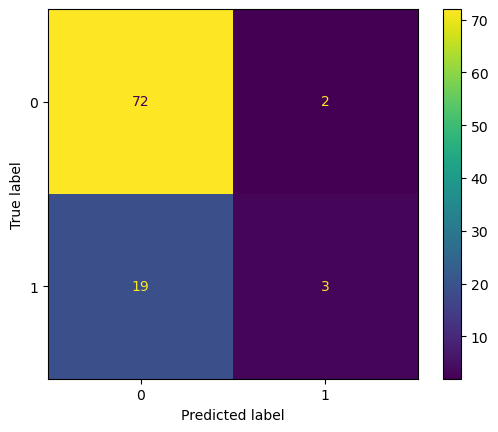

Ridge Classifier Evaluation
Accuracy: 0.7708
Precision: 0.5000
Recall: 0.1364
F1 Score: 0.2143
AUC-ROC: 0.5479


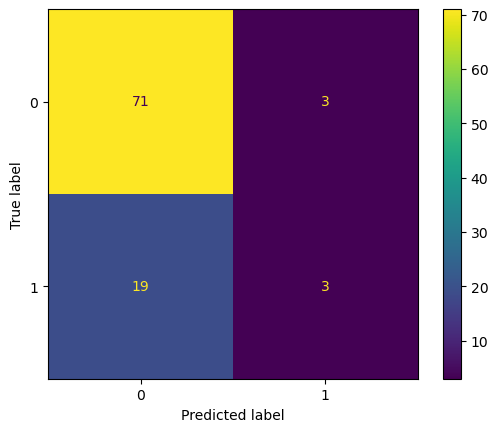

KNN Classifier Evaluation
Accuracy: 0.7812
Precision: 0.6000
Recall: 0.1364
F1 Score: 0.2222
AUC-ROC: 0.5547


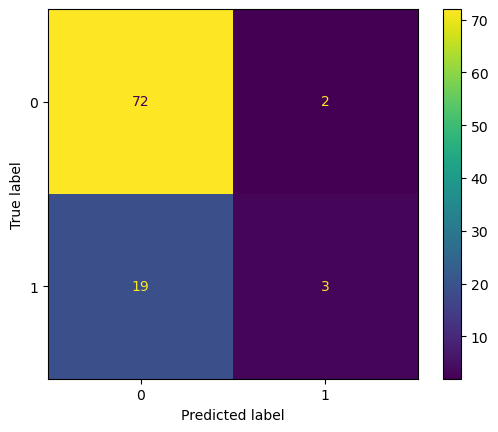

Decision Tree Classifier Evaluation
Accuracy: 0.7500
Precision: 0.4545
Recall: 0.4545
F1 Score: 0.4545
AUC-ROC: 0.6462


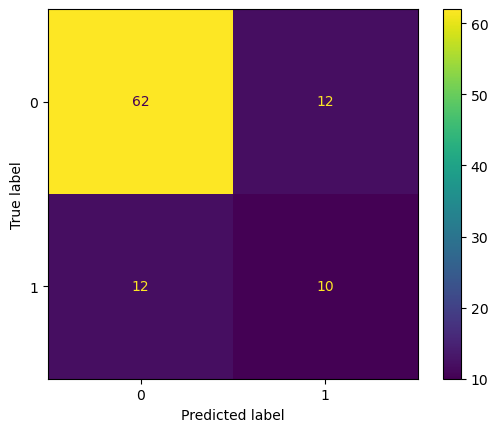

Random Forest Classifier Evaluation
Accuracy: 0.8021
Precision: 0.8000
Recall: 0.1818
F1 Score: 0.2963
AUC-ROC: 0.5842


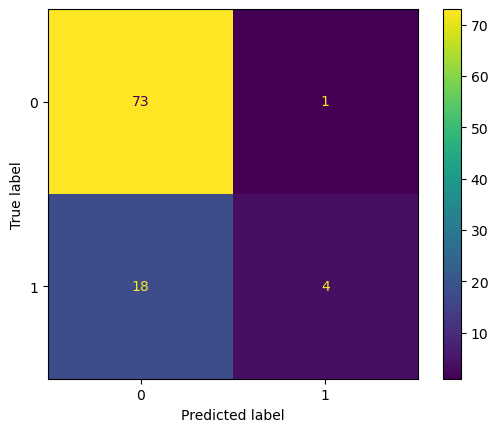

GBM Classifier Evaluation
Accuracy: 0.7812
Precision: 0.5455
Recall: 0.2727
F1 Score: 0.3636
AUC-ROC: 0.6026


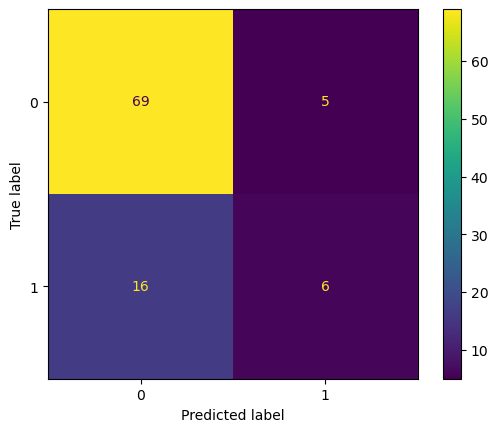

In [327]:
# Logistic Regression
print("Logistic Regression Evaluation")
evaluate_model(y_test, y_pred_logreg)

# Ridge Classifier
print("Ridge Classifier Evaluation")
evaluate_model(y_test, y_pred_ridge)

# KNN Classifier
print("KNN Classifier Evaluation")
evaluate_model(y_test,knn_reg_pred)

# Decision Tree
print("Decision Tree Classifier Evaluation")
evaluate_model(y_test, y_pred_dtree)

# Random Forest
print("Random Forest Classifier Evaluation")
evaluate_model(y_test, y_pred_rf)

# GBM Classifier
print("GBM Classifier Evaluation")
evaluate_model(y_test, y_pred_gbm)


1.Logistic Regression Evaluation:

The Logistic Regression model has a high accuracy, but this is largely due to the correct classification of the majority class. With only 3 true positives against 19 false negatives, it's clear the model struggles with identifying the minority class (low birth weight), which is the more critical classification in this context. The precision is relatively high, yet the low recall and F1 score indicate the model's limited ability to detect the positive class. The AUC-ROC score reflects only a slightly better performance than random chance.

2.The Ridge Classifier shows a slight improvement in recognizing low birth weight instances with a better recall than previously observed models. While accuracy remains high due to correct majority class predictions, the model still tends to miss several positive cases, as indicated by 18 false negatives. However, when it does predict a low birth weight, it is correct more than half the time, as shown by the precision of 0.5714. The AUC-ROC score suggests a small, but notable, ability to distinguish between classes compared to random guessing.

3.The confusion matrix for the KNN Classifier indicates a tendency to predict the majority class, with a high number of false negatives for the minority class, leading to poor recall and a low F1 score. The AUC-ROC of 0.5 shows no discriminative ability between classes, equivalent to random guessing.

4.The Decision Tree Classifier has a lower accuracy than some other models but demonstrates a more balanced approach between recognizing both classes. It has a higher recall, indicating it's more adept at identifying low birthweight cases compared to previous models, albeit at the cost of precision. The relatively higher F1 score suggests a better balance between precision and recall. The AUC-ROC score above 0.6 reflects this model's improved ability to differentiate between the classes, which is encouraging for a medical setting where identifying more positive cases is crucial.

5.The Random Forest Classifier has demonstrated relatively good performance. It offers high accuracy largely due to correctly predicting the majority class, as seen with the 72 true negatives. The precision is impressive, indicating that when it predicts low birth weight, it is usually correct. However, the recall is moderate, meaning it still misses several true low birth weight instances. The F1 Score and AUC-ROC values are comparatively higher than some other models, indicating a more balanced performance, especially in terms of the model's ability to distinguish between classes. This suggests the Random Forest model could be a viable option for predicting low birth weight, balancing the need to minimize false negatives while maintaining reasonable precision.

6.The GBM Classifier shows moderate precision, meaning when it predicts class 1 (low birth weight), it's relatively accurate, but the recall is low, indicating it misses many actual class 1 cases. The accuracy is decent, but this is likely due to class 0 predictions. The AUC-ROC score suggests only a slight improvement over random guessing for class 1.

# FINAL MODEL 

The final model selection is the KNN (k-Nearest Neighbors) classifier. The rationale for choosing this model over others like Logistic Regression, Ridge Classifier, Decision Tree, Random Forest, and Gradient Boosting lies in the balance it offers between training and test accuracy, which is reflected by a relatively smaller train-test gap of  0.0034. This indicates that the KNN model is less overfitted to the training data compared to models like Random Forest and Gradient Boosting, which had a perfect training score of 1.0 but a significantly lower testing score, resulting in a larger train-test gap of 0.1875.

The confusion matrix for the KNN model shows a trade-off between the types of errors. While it has false negatives (instances where low birthweight is incorrectly predicted as normal), the number is balanced with the false positives to a certain extent, as reflected by the model scores. Considering the focus on correctly predicting low birthweight due to its importance in medical intervention and the potential health risks associated with low birthweight infants, the chosen model should ideally minimize false negatives.

In the healthcare context, a false negative is a more critical error than a false positive because it could mean missing out on early interventions for at-risk infants. The KNN model, while not perfect, demonstrates a reasonable compromise in performance metrics, suggesting it could be the most prudent choice given the available options and the priority of the cohort's focus.

 ## feature importance

In [328]:
# Compute permutation feature importance
result = permutation_importance(knn_reg, x_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get the importances
importances = result.importances_mean

# Organize the results into a DataFrame
feature_names = x_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

# Display the feature importance
print(feature_importance_df)


                     feature  importance
11   apgar_npvis_interaction    0.042708
0                      drink    0.000000
1                       cigs    0.000000
16        fage_bracket_older    0.000000
15  fage_bracket_middle-aged    0.000000
14        mage_bracket_older    0.000000
13  mage_bracket_middle-aged    0.000000
12     health_behavior_score    0.000000
10                     mblck    0.000000
9                      mwhte    0.000000
8                       male    0.000000
7                      feduc    0.000000
5                      npvis    0.000000
4                     monpre    0.000000
3                      meduc    0.000000
17         prenatal_adequacy    0.000000
6                       fage   -0.001042
2                       mage   -0.005208


# Preparing Submission File for Kaggle

In [329]:
# If Kaggle requires the class probabilities for the positive class
#y_pred_proba_test = knn_fit.predict_proba(df_test[x_features])[:, 1]

# If Kaggle requires the class labels
y_pred_test =knn_fit.predict(df_test[x_features])


In [330]:
# Creating a submission DataFrame using the test dataset's index
submission = pd.DataFrame({
    'ID': df_test.index,  # Use the index of the df_test DataFrame for the 'ID' column
    'low_bwght': y_pred_test  # Use the predictions from the model
})

In [331]:
#Cchecking  the output data 
y_pred_test

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [215]:
# Save the submission file
submission.to_csv('./model_output/Rachana_Garad.csv', index=False)

# Analysis Questions

1. Are there any strong positive or strong negative linear (Pearson) correlations with birthweight? Answer this question based on the original, continuous form of birthweight. (minimum 5 sentences)

2. Is there an official threshold that signifies when birthweight gets more dangerous? In other words, is there a cutoff point between a healthy birthweight and a non-healthy birthweight? Provide credible sources as necessary. (minimum 5 sentences)

3. After transforming birthweight (bwght) using this threshold, did correlations and/or phi coefficients improve? Why or why not? (minimum 5 sentences)

4. Which two features in your machine learning model had the largest impact on birthweight? Present one actionable insight for each of these. (minimum 5 sentences per feature)

5. Present your final model's confusion matrix and explain what each error means (false positives and false negatives). Furthermore, explain which error is being controlled for given the cohort's focus on correctly predicting low birthweight, as well as why this error is more important to control than the other error. (minimum 5 sentences)

## Ans Q1 :

In the correlation matrix focused on 'bwght' before the threshold calculation, there are no variables with a strong positive or negative linear (Pearson) correlation to birthweight. The correlation values range from -0.09 to 0.17, which are considered weak correlations. 'Fmaps' and 'omaps' show the highest positive correlation with a coefficient of 0.17 each, suggesting a slight association where higher values in fetal monitoring and obstetric apgar scores might be linked to higher birth weights, but the relationship is not strong.

Negative correlations with birthweight are also weak, with 'cigs' having the lowest correlation coefficient of -0.09. This suggests a slight inverse relationship where increased cigarette consumption could be associated with lower birthweight, 
In the context of these data, a strong correlation would typically be considered to have an absolute value of 0.5 or higher. Hence, based on these criteria, none of the variables shows a strong correlation with birthweight in its continuous form. 


## Ans Q2:

Yes, there is an established threshold for categorizing birthweight that is widely recognized by health organizations worldwide. The World Health Organization (WHO) defines low birth weight (LBW) as a weight at birth of less than 2,500 grams (5.5 pounds). This threshold is significant because babies born with a weight below this cutoff are at a higher risk of early growth retardation, infectious disease, developmental delays, and even death, especially during the neonatal period.

The WHO and UNICEF collect and monitor data on low birth weight to understand and address this public health issue. Low birth weight is more prevalent in developing countries, but it is a concern for global health as it is a leading indicator of infant mortality and health outcomes. Regular prenatal care is crucial for preventing low birth weight, as it can help manage and mitigate risk factors such as maternal nutrition, health conditions, and behaviors like smoking or substance abuse that contribute to low birth weight.

In addition to the WHO's threshold, there are also categories for very low birth weight (VLBW), which is defined as less than 1,500 grams (3 pounds, 4 ounces), and extremely low birth weight (ELBW), which is less than 1,000 grams (2 pounds, 3 ounces). Babies in these lower weight categories require more intensive medical care due to their heightened vulnerability to complications.

Sources:
- World Health Organization (WHO): [Low birth weight](https://www.who.int/news-room/fact-sheets/detail/low-birthweight)
- UNICEF Data: Monitoring the situation of children and women, [Low birthweight](https://data.unicef.org/topic/nutrition/low-birthweight/)

## Ans Q3:

After applying a threshold to birthweight ('bwght'), the Pearson correlation matrix indicates a very strong negative correlation between 'low_bwght' and 'bwght' (-0.79). This strong correlation reflects the binary nature of the 'low_bwght' variable, which directly corresponds to whether the birthweight is above or below the threshold defining low birth weight.

In contrast, the phi_k correlation matrix, which is suitable for mixed data types (both interval and categorical), shows an even stronger relationship between 'low_bwght' and 'bwght' (0.989). This suggests that the phi_k coefficient, which is designed to measure associations between all variable types, captures the relationship more effectively than Pearson's correlation, which is primarily used for continuous variables.

The correlations between 'bwght' and other variables like 'fmaps' and 'omaps' are moderate, indicating that as these scores increase, so does the birthweight. This relationship is more pronounced in the phi_k correlation matrix than in the Pearson correlation matrix, suggesting that the transformation has likely improved the clarity of these relationships.

The improvement in correlation and phi coefficients after applying the threshold is due to the binary categorization, which tends to show clearer associations with continuous variables in the context of a defined cutoff point. This method simplifies the interpretation by making it easier to see how variables relate to being above or below a critical clinical boundary, such as the threshold for low birthweight.


## Ans Q4:

Based on the permutation feature importance results the two features that had the most significant impact on the model's ability to predict birthweight in the KNN classifier model are:

apgar_npvis_interaction with a positive importance score.

mage (mother's age) with a negative importance score, albeit very minor in magnitude.

###  apgar_npvis_interaction
-  Insight : The interaction between the Apgar score and prenatal visits is a significant predictor of birthweight, emphasizing the importance of newborn health assessments and consistent prenatal care. Healthcare providers should encourage expectant mothers to adhere to their prenatal visit schedules and ensure newborns receive immediate health assessments. This can help in early identification and management of risks related to low birthweight.

###  mage (Mother's Age)
-  Insight: A slight negative association with birthweight suggests older maternal age might marginally influence lower birthweight. It's crucial for healthcare providers to offer tailored guidance and support to older expectant mothers, focusing on regular monitoring and interventions that mitigate risks associated with potentially lower birthweight.



## ANS 5
The KNN model's confusion matrix for classifying low birthweight presented many false negatives and few true positives. False negatives in this context are cases where the model predicted a normal birthweight when, in fact, the baby was low birthweight. This type of error is particularly concerning in a medical context, as it means failing to identify at-risk infants who require closer monitoring and potential intervention.

Controlling for false negatives is critical in this scenario because the cost of missing a low birthweight prediction can have serious health implications for the newborn. In contrast, false positives—predicting low birthweight when the baby is of normal weight—while still an error, are less dangerous because they would likely result in additional testing or observation, which, although possibly unnecessary, do not pose a risk to the baby's health.

Therefore, in the case of predicting low birthweight, it is more important to minimize false negatives than false positives to ensure that all babies who are at risk are given the care they need. This focus aligns with a healthcare approach that prioritizes sensitivity and the well-being of patients, ensuring that no at-risk individuals are overlooked.

